In [ ]:
 # Run this cell to mount your google drive so that we can access files on your google drive.
 from google.colab import drive 
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

GOOGLE_DRIVE_PATH_STR = '442 Final Project'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_STR)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Reports', 'NYU_Dataset', 'deep_ordinal_NN.pdf', 'transfer_learning.pdf', 'model_params.pt', 'checkpoints', 'rajiv_checkpoints', 'charlie_checkpoints', 'reuben_checkpoints', 'isaac_checkpoints', 'isaac_model.ipynb', 'charlie_model.ipynb', 'reuben_model.ipynb', 'model_old.ipynb', 'model.ipynb']


In [ ]:
# Load the autoreload extension
%load_ext autoreload 
%autoreload 2

import sys 
sys.path.append(GOOGLE_DRIVE_PATH)

In [ ]:
# Import modules
import pickle
import pandas as pd
import numpy as np
import torch
import torchvision
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy.random import default_rng
import matplotlib.pyplot as plt
import torch.nn as nn
import math
%matplotlib inline

Check if GPU is available. If device = 'cpu', in the toolbar, click Runtime -> Change runtime type -> select GPU as hardware accelerator.

In [ ]:
 device = 'cuda' if torch.cuda.is_available() else 'cpu' 
 print(device)

cuda


# Load in the labeled NYU_Dataset

In [ ]:
dict_of_numpy = pickle.load(open(os.path.join(GOOGLE_DRIVE_PATH, 'NYU_Dataset/nyu_depth_v2_labeled.pkl'), 'rb'))

In [ ]:
keys = dict_of_numpy.keys()
keys

dict_keys(['images', 'depths'])

In [ ]:
# save a numpy representation of images
array_images = np.moveaxis(dict_of_numpy['images'], -1, 1)
# save a numpy representation of depths
array_depths = np.expand_dims(dict_of_numpy['depths'], axis=1)
# get a count of images (same as depths)
num_images_depths = len(array_images)
image_shape = array_images[5].shape
depth_shape = array_depths[31].shape

In [ ]:
print('The number of images and depths is...', num_images_depths)
print('The shape of each image is...', image_shape)
print('The shape of each depth is...', depth_shape)

The number of images and depths is... 1449
The shape of each image is... (3, 640, 480)
The shape of each depth is... (1, 640, 480)


## Defining the Dataset class

In [ ]:
class NYU_Dataset(torch.utils.data.Dataset):
  def __init__(self, array_images, array_depths):
    self.images = torch.from_numpy(array_images)
    self.depths = torch.from_numpy(array_depths)

  def __len__(self):
        return self.images.shape[0]

  def __getitem__(self, index):
        return self.images[index].float(), self.depths[index]

## Defining Dataloaders

In [ ]:
per_train = 0.8
per_validation = 0.1
per_test = 0.1
batch_size = 8
N = len(array_images)

rng = default_rng(42)
perm = rng.permutation(N)

partition = {}
partition['train'] = perm[:int(N * per_train)]
partition['validate'] = perm[int(N * per_train) : int(N * (per_train + per_validation))]
partition['test'] = perm[int(N * (per_train + per_validation)):]
print(f'Train set shape: {partition["train"].shape}')
print(f'Validation set shape: {partition["validate"].shape}')
print(f'Test set shape: {partition["test"].shape}')

training_set = NYU_Dataset(array_images[partition['train']], array_depths[partition['train']])
tr_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

validation_set = NYU_Dataset(array_images[partition['validate']], array_depths[partition['validate']])
va_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)

test_set = NYU_Dataset(array_images[partition['test']], array_depths[partition['test']])
te_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

Train set shape: (1159,)
Validation set shape: (145,)
Test set shape: (145,)


# Defining the model architecture

In [ ]:
class Conv_Depth(nn.Module):
  def __init__(self):
    super(Conv_Depth, self).__init__()
    self.encoder = torchvision.models.densenet201(pretrained=True)
    self.decoder = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'), # 1
        
        nn.Conv2d(1920, 1024, kernel_size=3, padding=1), # 2
        nn.BatchNorm2d(num_features=1024),
        nn.ReLU(inplace=True), # 2
        nn.Conv2d(1024, 1024, kernel_size=3, padding=1), # 2
        nn.BatchNorm2d(num_features=1024),
        nn.ReLU(inplace=True), # 2

        nn.Upsample(scale_factor=2, mode='nearest'), # 1

        nn.Conv2d(1024, 512, kernel_size=3, padding=1), # 2
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(inplace=True), # 2
        nn.Conv2d(512, 512, kernel_size=3, padding=1), # 2
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(inplace=True), # 2

        nn.Upsample(scale_factor=2, mode='nearest'), # 3
 
        nn.Conv2d(512, 256, kernel_size=3, padding=1), # 4
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(inplace=True), # 4
        nn.Conv2d(256, 256, kernel_size=3, padding=1), # 4
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(inplace=True), # 4
        
        nn.Upsample(scale_factor=2, mode='nearest'), # 3
 
        nn.Conv2d(256, 128, kernel_size=3, padding=1), # 4
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(inplace=True), # 4
        nn.Conv2d(128, 128, kernel_size=3, padding=1), # 4
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(inplace=True), # 4

        nn.Upsample(scale_factor=2, mode='nearest'), # 3

        nn.Conv2d(128, 64, kernel_size=3, padding=1), # 4
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(inplace=True), # 4
        nn.Conv2d(64, 1, kernel_size=3, padding=1), # 4
        )

    self.decoder.apply(self.init_weights)

  def init_weights(self, layer):
    if type(layer) == nn.Conv2d:
      C_in = layer.weight.size(1)
      nn.init.normal_(layer.weight, 0.0, 1 / math.sqrt(5 * 5 * C_in))
      nn.init.constant_(layer.bias, 0.0)

    if type(layer) == nn.Linear:
      torch.nn.init.xavier_uniform(layer.weight)
      layer.bias.data.fill_(0.01)
      # m.weight.data.uniform_(0.0, 1.0)
      # m.bias.data.fill_(0)
      

  def forward(self, x):
    x = self.encoder.features(x)
    x = self.decoder(x)
    return x
    

# Training the Model

In [ ]:
def train_epoch(data_loader, model, optimizer, criterion):
  batch_multiplier = 8
  count = 0
  for X, y in data_loader:
    X = X.to(device)
    y = y.to(device)

    # optimizer.zero_grad()
    # outputs = model(X)
    # loss = criterion(outputs, y)
    # loss.backward()
    # optimizer.step()

    if count == 0:
        optimizer.step()
        optimizer.zero_grad()
        
        count = batch_multiplier
    
    outputs = model(X)
    loss = criterion(outputs, y) / batch_multiplier
    loss.backward()
    
    count -= 1

def get_metrics(data_loader, model, criterion):
  with torch.no_grad():
        y_true, y_pred = [], []
        total = 0
        running_loss = []
        rms_error = 0.0
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            predicted = model(X)
            y_true.append(y)
            y_pred.append(predicted)
            total += y.size(0)
            running_loss.append(criterion(predicted, y).item())
            rms_error += mean_squared_error(torch.flatten(y.cpu().detach(), start_dim=1).numpy(), 
                                            torch.flatten(predicted.cpu().detach(), start_dim=1).numpy())
        loss = np.mean(running_loss)
        rms_error /= total
        return loss, rms_error

def evaluate_epoch(tr_loader, va_loader, model, criterion, epoch, stats):
  train_loss, train_mse = get_metrics(tr_loader, model, criterion)
  val_loss, val_mse = get_metrics(va_loader, model, criterion)

  stats.append([val_mse, val_loss, train_mse, train_loss])
  print('Epoch {}'.format(epoch))
  print('\tValidation Loss: {}'.format(val_loss))
  print('\tValidation MSE: {}'.format(val_mse))
  print('\tTrain Loss: {}'.format(train_loss))
  print('\tTrain MSE: {}'.format(train_mse))

  return stats

def plot_results(axes, epoch, stats):
  valid_acc = [s[0] for s in stats]
  valid_loss = [s[1] for s in stats]
  train_acc = [s[2] for s in stats]
  train_loss = [s[3] for s in stats]
  axes[0].plot(range(epoch - len(stats) + 1, epoch + 1), valid_acc,
      linestyle='--', marker='o', color='b')
  axes[0].plot(range(epoch - len(stats) + 1, epoch + 1), train_acc,
      linestyle='--', marker='o', color='r')
  axes[0].legend(['Validation', 'Train'])
  axes[1].plot(range(epoch - len(stats) + 1, epoch + 1), valid_loss,
      linestyle='--', marker='o', color='b')
  axes[1].plot(range(epoch - len(stats) + 1, epoch + 1), train_loss,
      linestyle='--', marker='o', color='r')
  axes[1].legend(['Validation', 'Train'])
  plt.pause(0.00001)


In [ ]:
%time

learning_rate = 1e-4
num_epochs = 8
weight_decay = 1e-4

def main():
  # initializing model hyperparameters
  stats = []
  model = Conv_Depth().to(device)
  # print(summary(model.encoder.features, (3, 640, 480)))
  optimizer = torch.optim.Adam(model.decoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
  criterion = torch.nn.L1Loss()

  # freezing the parameters of the squeeze-net encoder
  for param in model.encoder.parameters():
    param.requires_grad = False

  # training and evaluating model
  stats = evaluate_epoch(tr_loader, va_loader, model, criterion, -1, stats)
  for epoch in range(num_epochs):
    if epoch % 1 == 0:
      torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': stats[-1][3],
              'stats': stats
              }, (GOOGLE_DRIVE_PATH + f'/checkpoints/model_{epoch}.pt'))
    train_epoch(tr_loader, model, optimizer, criterion)
    stats = evaluate_epoch(tr_loader, va_loader, model, criterion, epoch, stats)

  test_loss, test_mse = get_metrics(te_loader, model, criterion)
  print(f'Test Loss: {test_loss}')
  print(f'Test MSE: {test_mse}')

  
  torch.save(model.state_dict(), (GOOGLE_DRIVE_PATH + '/checkpoints/model_params.pt'))
  
  return stats

stats = main()

  


CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.29 µs
Epoch -1
	Validation Loss: 2.780629986210873
	Validation MSE: 1.2623391118542902
	Train Loss: 2.8063679168964253
	Train MSE: 1.2414835653395566
Epoch 0
	Validation Loss: 1.7421871423721313
	Validation MSE: 0.7322960426067484
	Train Loss: 1.745323188551541
	Train MSE: 0.7177493944571284
Epoch 1
	Validation Loss: 1.4742571993878013
	Validation MSE: 0.5493768412491371
	Train Loss: 1.4369655448814918
	Train MSE: 0.5206071064326144
Epoch 2
	Validation Loss: 1.1971646672800969
	Validation MSE: 0.4075061411693178
	Train Loss: 1.152909832165159
	Train MSE: 0.3755423484741356
Epoch 3
	Validation Loss: 0.9422885650082639
	Validation MSE: 0.2633648074906448
	Train Loss: 0.9428863126656105
	Train MSE: 0.25414326799851844
Epoch 4
	Validation Loss: 0.8576584176013344
	Validation MSE: 0.1976929993465029
	Train Loss: 0.8133156357140376
	Train MSE: 0.1751721708603827
Epoch 5
	Validation Loss: 0.8513855275354887
	Validation MSE: 0.22138

# Results


In [ ]:
def recover_model(checkpoint_path, model_class):
  model = model_class()
  model.load_state_dict(torch.load(GOOGLE_DRIVE_PATH + checkpoint_path)["model_state_dict"])
  return model

# def show_results(model, input, depths):
#   outputs = model(input)
#   fig, axs = plt.subplots(len(outputs), 2)
#   images = outputs.detach().numpy().reshape((-1, 640, 480))
#   images = images / np.max(images, axis=(1,2), keepdims=True)
#   for i, img in enumerate(images):
#     axs[i][0].imshow(img.reshape((640,480)))
#     axs[i][1].imshow(depths[i].reshape((640, 480)))

def show_results(model, input, original, expected):
  outputs = model(input)
  fig, axs = plt.subplots(len(outputs), 3)
  images = outputs.detach().numpy().reshape((-1, 640, 480))
  images = images / np.max(images, axis=(1,2), keepdims=True)
  for i, img in enumerate(images):
    axs[i][0].imshow(np.rot90(np.moveaxis(original[i], 0, -1), 3))
    axs[i][1].imshow(np.rot90(img.reshape((640,480)), 3))
    axs[i][2].imshow(np.rot90(expected[i].reshape((640, 480)), 3))
    axs[i][0].set_yticklabels([])
    axs[i][0].set_xticklabels([])
    axs[i][1].set_yticklabels([])
    axs[i][1].set_xticklabels([])
    axs[i][2].set_yticklabels([])
    axs[i][2].set_xticklabels([])

  cols = ["Original", "Predicted", "Expected"]
  for ax, col in zip(axs[0], cols):
    ax.set_title(col)

In [ ]:
model_recovered = recover_model("/checkpoints/model_7.pt", Conv_Depth)

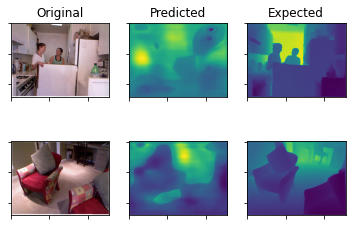

In [ ]:
show_results(model_recovered, torch.from_numpy(array_images[partition['test'][34:36]]).float(), array_images[partition['test'][34:36]], array_depths[partition['test'][34:36]])

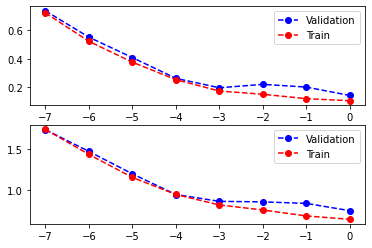

In [ ]:
fig, axis = plt.subplots(2)
plot_results(axis, 0, stats[1:])# plot_results(axis, 0, stats[1:])
plt.show()

In [1]:
# model = Conv_Depth()
# model.load_state_dict(torch.load(GOOGLE_DRIVE_PATH+ "/checkpoints/model_params.pt"))
# model.eval()
# outputs = model(torch.from_numpy(array_images[partition['test'][0:2]]).float())


In [2]:
# img = outputs[1].detach().numpy().squeeze()
# img = img / np.max(img)

In [3]:
# np.mean(img)

In [4]:
# np.std(img)

In [5]:
# np.mean(array_depths[partition['test'][1]])

In [6]:
# partition['test'][1]

In [7]:
# np.std(array_depths[partition['test'][1]])

In [8]:
# plt.imshow(img)

In [9]:
# plt.imshow(array_depths[partition['test'][1]].squeeze())